In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import time 

df = pd.read_pickle('data/pkl/PreciosOF.xlsx.pkl')
df

,Fecha,Compra,Venta
1,2023-01-27,183.74,192.74
2,2023-01-26,183.74,192.74
3,2023-01-25,183.26,192.26
4,2023-01-24,183.08,192.08
5,2023-01-23,182.68,191.68
...,...,...,...
3220,2010-01-07,3.79,3.83
3221,2010-01-06,3.79,3.83
3222,2010-01-05,3.78,3.82
3223,2010-01-04,3.78,3.82


In [38]:
# renaming for fbprophet
df.rename(columns={'Fecha':'ds'}, inplace=True)
df.rename(columns={'Venta':'y'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,ds,Compra,y
0,1,2023-01-27,183.74,192.74
1,2,2023-01-26,183.74,192.74
2,3,2023-01-25,183.26,192.26
3,4,2023-01-24,183.08,192.08
4,5,2023-01-23,182.68,191.68


In [39]:
df.rename(columns={'Fecha':'ds'}, inplace=True)

In [40]:
df = df[df['ds'] >= '2018-01-01']

df

,index,ds,Compra,y
0,1,2023-01-27,183.74,192.74
1,2,2023-01-26,183.74,192.74
2,3,2023-01-25,183.26,192.26
3,4,2023-01-24,183.08,192.08
4,5,2023-01-23,182.68,191.68
...,...,...,...,...
1265,1266,2018-01-05,18.86,19.26
1266,1267,2018-01-04,18.56,18.96
1267,1268,2018-01-03,18.38,18.78
1268,1269,2018-01-02,18.36,18.76


In [41]:
df.drop(['Compra'], axis=1)

,index,ds,y
0,1,2023-01-27,192.74
1,2,2023-01-26,192.74
2,3,2023-01-25,192.26
3,4,2023-01-24,192.08
4,5,2023-01-23,191.68
...,...,...,...
1265,1266,2018-01-05,19.26
1266,1267,2018-01-04,18.96
1267,1268,2018-01-03,18.78
1268,1269,2018-01-02,18.76


In [42]:
df = df.sort_values(by='ds')

In [43]:
df['y'].round(2).describe()

count    1270.000000
mean       81.060465
std        42.059862
min        18.760000
25%        43.655000
50%        77.405000
75%       105.617500
max       193.900000
Name: y, dtype: float64

In [44]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(df)

22:27:51 - cmdstanpy - INFO - Chain [1] start processing
22:27:54 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
future_dataset= prophet_model.make_future_dataframe(periods=1, freq='y') # Data para el proximo año
future_dataset.tail()

,ds
1230,2023-01-25
1231,2023-01-26
1232,2023-01-27
1233,2023-01-30
1234,2023-12-31


In [46]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,17.971062,16.678609,19.385235
1,2018-01-03,18.095767,16.713976,19.548346
2,2018-01-04,18.280512,16.922047,19.579806
3,2018-01-05,18.420141,17.057357,19.830304
4,2018-01-08,18.746563,17.375465,20.084569


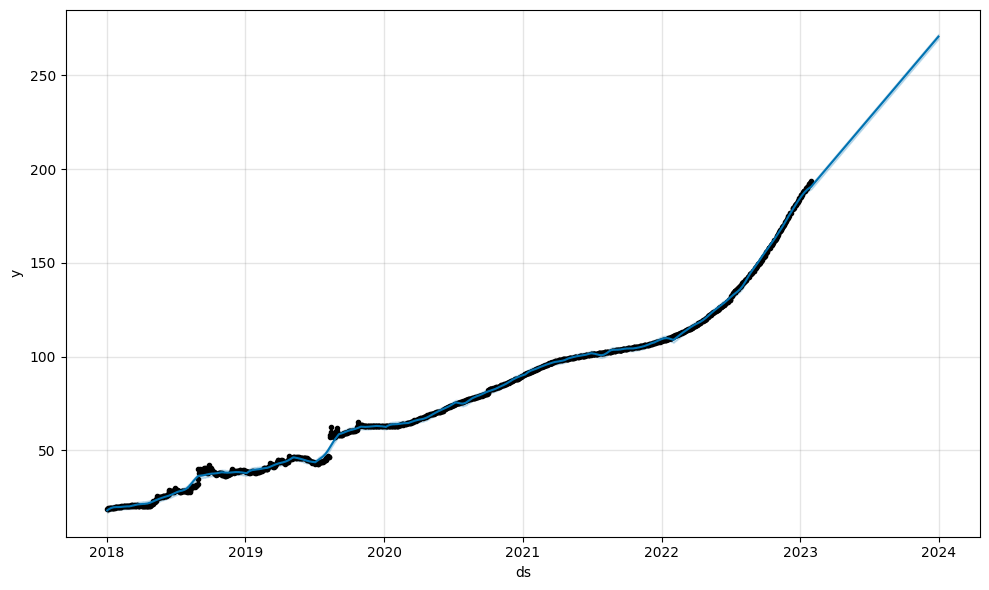

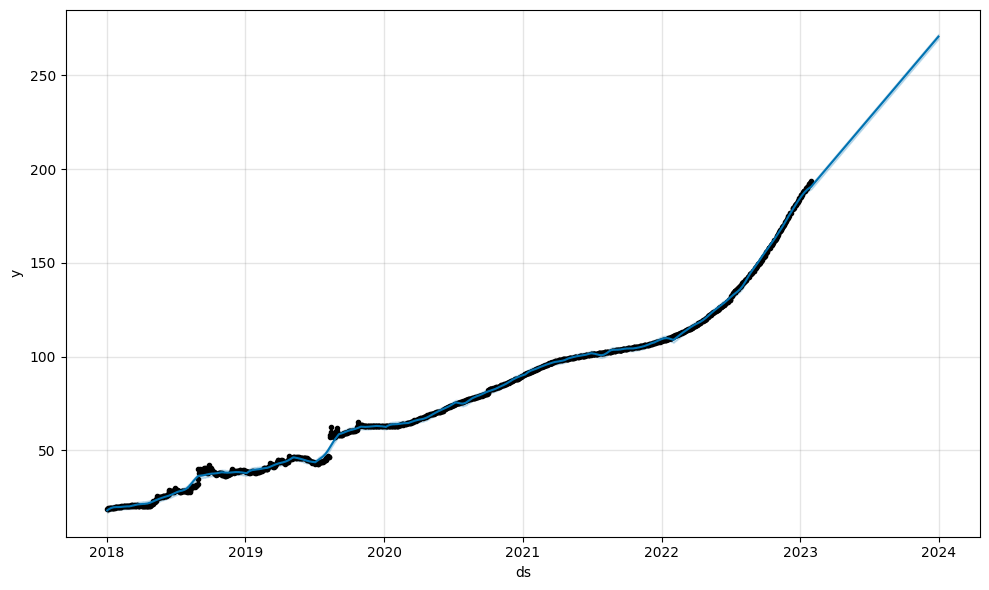

In [47]:
prophet_model.plot(pred)

In [48]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [49]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:28:18 - cmdstanpy - INFO - Chain [1] done processing


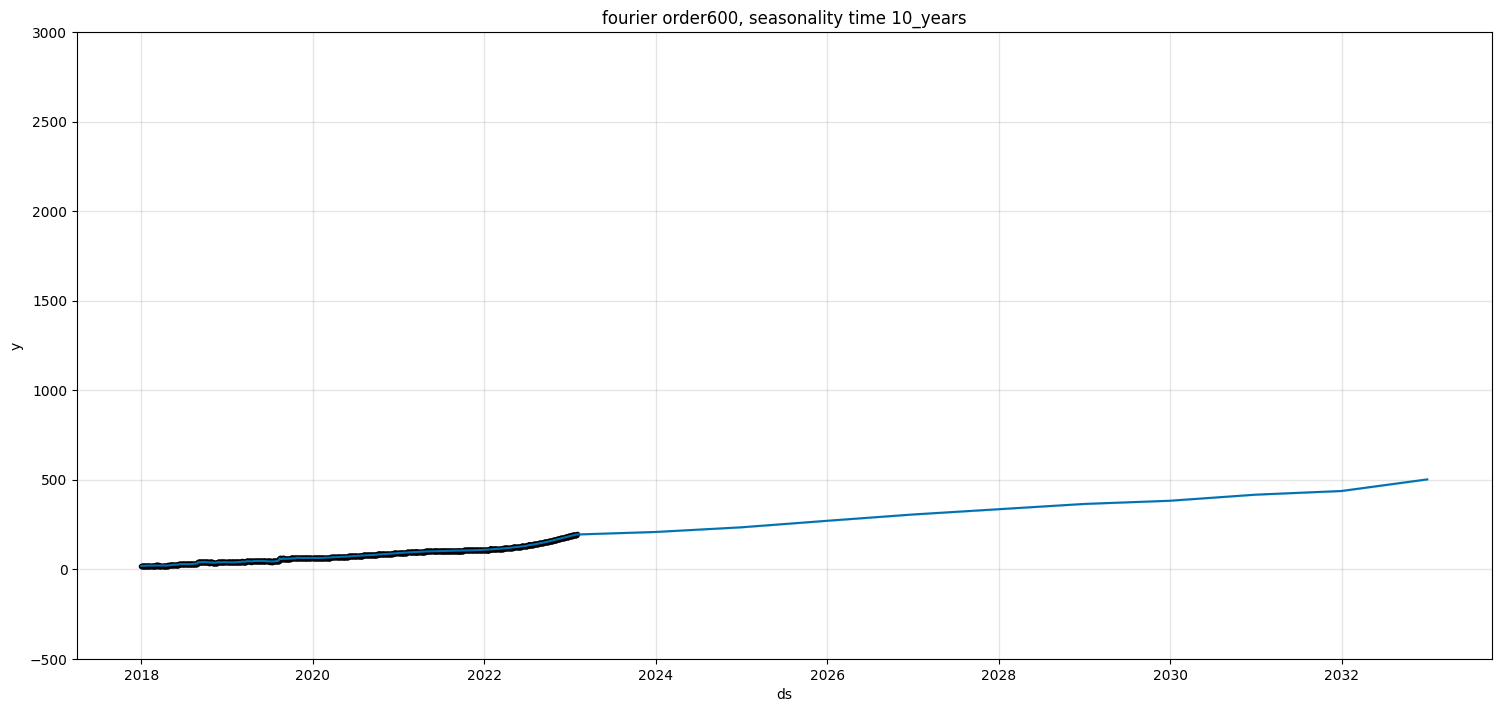

Total Execution Time 23.47732663154602 seconds


In [50]:
import time

training_set = df
validation_set = df 

ten_years = fb_prophet_function(data=training_set, future_years=10, seasonality_name='10_years', seasonality_val=365*10, seasonality_fourier=600,seasonality_mode='additive')

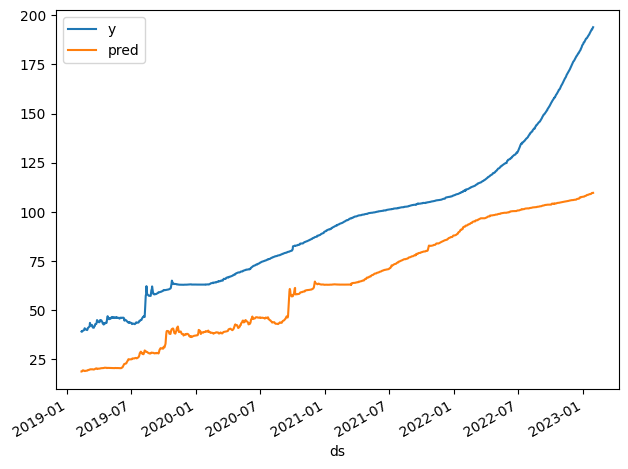

In [51]:
plot_valid(validation_set, 1000, ten_years)

In [52]:
pred = pred[['ds', 'yhat']]

pred

,ds,yhat
0,2018-01-02,17.971062
1,2018-01-03,18.095767
2,2018-01-04,18.280512
3,2018-01-05,18.420141
4,2018-01-08,18.746563
...,...,...
1230,2023-01-25,189.954643
1231,2023-01-26,190.144802
1232,2023-01-27,190.292534
1233,2023-01-30,190.671421


In [53]:
validation_set = validation_set[['ds', 'y']]

validation_set

,ds,y
1268,2018-01-02,18.76
1267,2018-01-03,18.78
1266,2018-01-04,18.96
1265,2018-01-05,19.26
1264,2018-01-08,19.34
...,...,...
3,2023-01-24,192.08
2,2023-01-25,192.26
1,2023-01-26,192.74
0,2023-01-27,192.74


In [54]:
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred

,ds,yhat
0,2018-01-02,17.971062
1,2018-01-03,18.095767
2,2018-01-04,18.280512
3,2018-01-05,18.420141
4,2018-01-08,18.746563
...,...,...
1229,2023-01-24,189.825954
1230,2023-01-25,189.954643
1231,2023-01-26,190.144802
1232,2023-01-27,190.292534


In [55]:
merged1 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged1[['ds', 'y']]
pred_ds_yhat = merged1[['ds', 'yhat']]


In [56]:
validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())

C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\2616818827.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\2616818827.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)

C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\476390056.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\476390056.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse1 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse1 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae1)
print("Mean Squared Error: ", mse1)
print("Root Mean Squared Error: ", rmse1)


Mean Absolute Error:  0.3731242931583415
Mean Squared Error:  0.5953545887720976
Root Mean Squared Error:  0.7715922425556763


In [59]:
df = df[df['ds'] >= '2021-01-01']

df

,index,ds,Compra,y
540,541,2021-01-04,84.22,90.22
539,540,2021-01-05,84.55,90.55
538,539,2021-01-06,84.55,90.55
537,538,2021-01-07,84.68,90.68
536,537,2021-01-08,84.79,90.79
...,...,...,...,...
3,4,2023-01-24,183.08,192.08
2,3,2023-01-25,183.26,192.26
1,2,2023-01-26,183.74,192.74
0,1,2023-01-27,183.74,192.74


22:28:22 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing


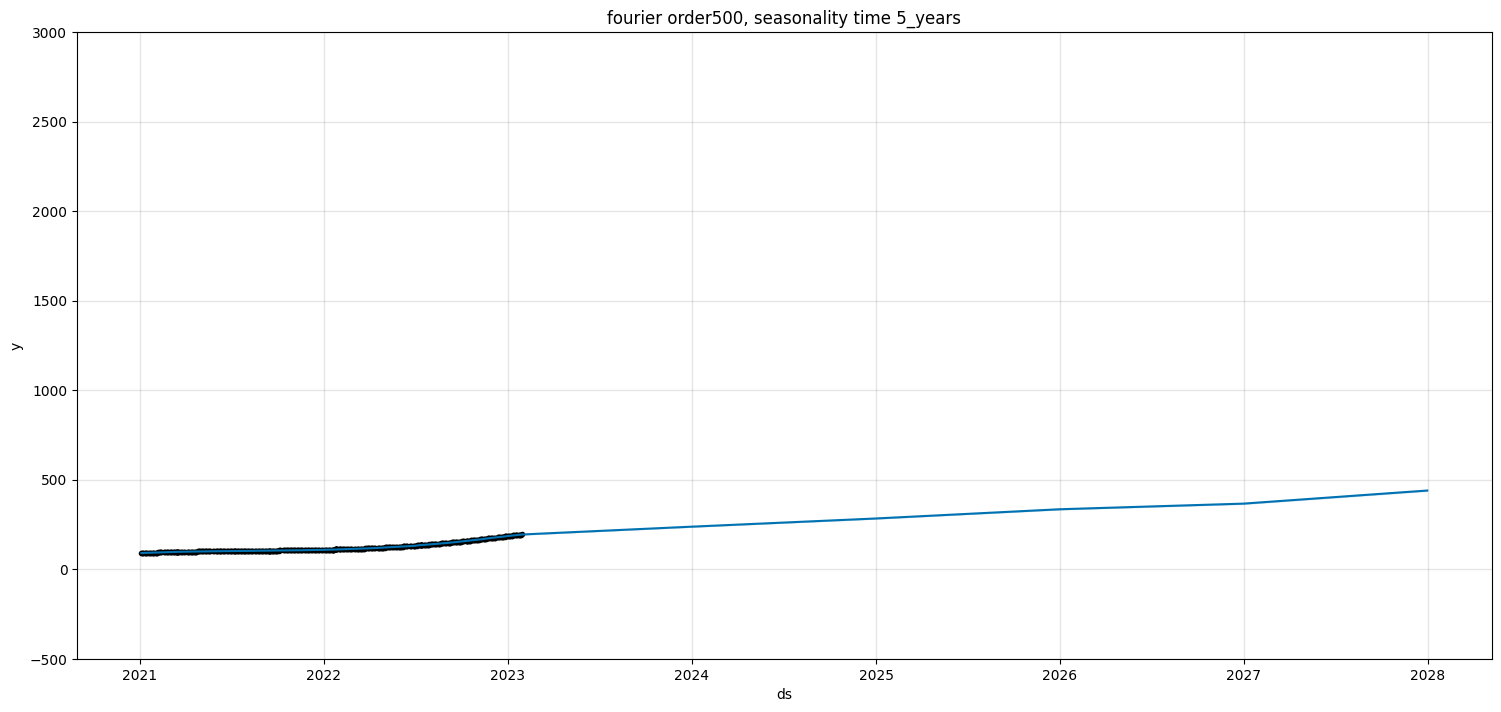

Total Execution Time 23.867544651031494 seconds


In [60]:
training_set = df
validation_set = df

five_years_model = fb_prophet_function(data=training_set, future_years=5, seasonality_name='5_years', seasonality_val=365*5, seasonality_fourier=500,seasonality_mode='additive')

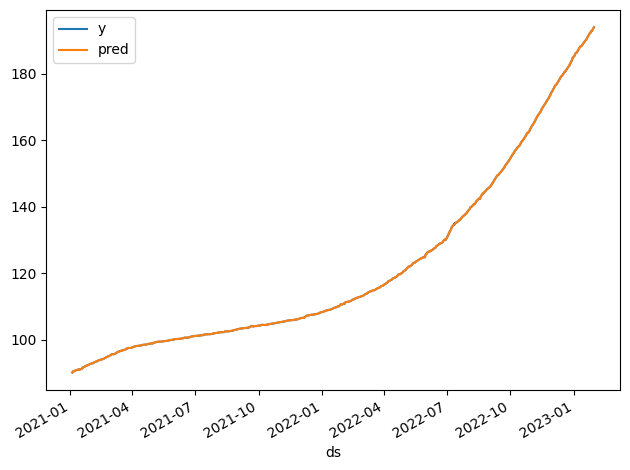

In [61]:
plot_valid(validation_set, 1000, five_years_model)

In [62]:
from sklearn.metrics import mean_squared_error

pred = pred[['ds', 'yhat']]

pred
validation_set = validation_set[['ds', 'y']]

validation_set
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred
merged2 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged2[['ds', 'y']]
pred_ds_yhat = merged2[['ds', 'yhat']]

validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)
import math

mae2 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse2 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse2 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae2)
print("Mean Squared Error: ", mse2)
print("Root Mean Squared Error: ", rmse2)


Mean Absolute Error:  0.29031752236059
Mean Squared Error:  0.28072731338472295
Root Mean Squared Error:  0.529837063053089


C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\3875005836.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\3875005836.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rodri\AppData\Local\Temp\ipykernel_10872\3875005836.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [63]:
from prophet import Prophet

five_years_model = Prophet(seasonality_mode='additive', seasonality_prior_scale=1, 
                         yearly_seasonality=True, weekly_seasonality=False, 
                         daily_seasonality=False)


In [64]:
five_years_model.add_seasonality(name='1_years', period=365*1, fourier_order=100)

In [65]:
import datetime

today = datetime.datetime.now()
next_month = today + datetime.timedelta(days=90)
start_date = today.strftime("%Y-%m-%d")
end_date = next_month.strftime("%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
next_month = pd.DataFrame({"ds": date_range})


In [66]:
five_years_model.fit(training_set)

prediction = five_years_model.predict(next_month)

22:28:46 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
values = prediction['yhat']

values_new = pd.DataFrame(values)

values_new = values_new.rename(columns={'yhat':'Values'})

values_new

,Values
0,193.878410
1,194.234200
2,194.553088
3,194.804666
4,195.124992
...,...
86,219.089554
87,219.434645
88,219.772382
89,220.082944


In [68]:
# import the datetime library
import datetime

# define the start date (today + 1) and the number of days in the range
start_date = datetime.datetime.today() + datetime.timedelta(days=1)
num_days = len(values_new.index)

# create the date range
date_range = [start_date.date() + datetime.timedelta(days=i) for i in range(num_days)]

# set the index of the dataframe to the date range
values_new.index = date_range

values_new


,Values
2023-01-31,193.878410
2023-02-01,194.234200
2023-02-02,194.553088
2023-02-03,194.804666
2023-02-04,195.124992
...,...
2023-04-27,219.089554
2023-04-28,219.434645
2023-04-29,219.772382
2023-04-30,220.082944


In [69]:
values_new.to_excel("data/xlsx/values_newOf.xlsx")

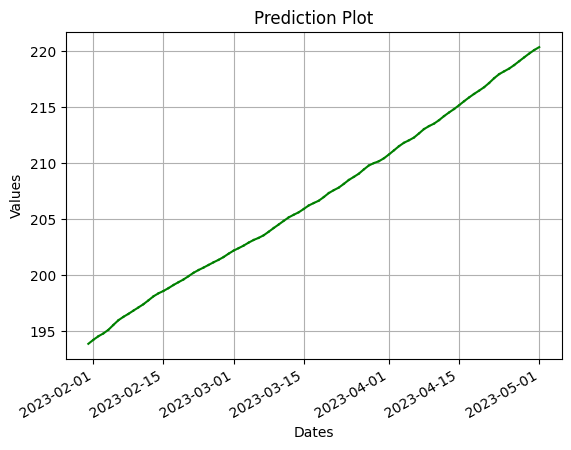

In [70]:
x = values_new.index
y = values_new['Values']
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'g'
    else:
        color = 'r'
    plt.plot(x[i-1:i+1], y[i-1:i+1], color=color)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Prediction Plot")
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()


In [71]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = []
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'green'
    else:
        color = 'red'
    trace = go.Scatter(x=x[i-1:i+1], y=y[i-1:i+1], mode='lines', line=dict(color=color, width=1), showlegend=False)
    data.append(trace)

layout = go.Layout(title='Prediccion Dolar Oficial', xaxis=dict(title='Fecha'), yaxis=dict(title='Valores'))
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [72]:
with open('data/html/Predicciones/Pred_DolarOF.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))